## Navegação Assistida por Visão Computacional (T3)

Este notebook implementa o pipeline principal para um sistema de navegação assistida, utilizando:
- **Detecção de Objetos:** YOLOv8n com tracking (ByteTrack).
- **Estimativa de Profundidade:** MiDaS (Small) para profundidade monocular relativa.
- **Processamento Temporal:** Filtro de Média Móvel Simples (SMA) para suavizar a profundidade.
- **Estimativa Métrica:** Conversão da profundidade relativa para metros (requer calibração).
- **Lógica de Navegação:** Geração de comandos direcionais básicos.
- **Feedback Auditivo:** Text-to-Speech (TTS) com rate limiting e detalhes do objeto.

In [1]:
# Bibliotecas Padrão
import time
import os
import json
import tempfile
import threading
from typing import List, Tuple
from collections import deque # Usado no filtro SMA

# Bibliotecas de Terceiros
import cv2
import torch
import numpy as np
from ultralytics import YOLO
from gtts import gTTS

# Configuração para display de áudio
try:
    from IPython.display import Audio, display
    # Tenta importar playsound para reprodução fora do Jupyter
    import playsound
    USE_PLAYSOUND = True
except ImportError:
    USE_PLAYSOUND = False
    print("[Aviso] Biblioteca 'playsound' não encontrada. O áudio será apenas salvo ou tentará usar IPython.display.")
    print("         Para tocar o áudio fora do Jupyter, instale: pip install playsound==1.2.2")

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [2]:
from transformers import RTDetrForObjectDetection, RTDetrImageProcessor
from PIL import Image

### Carregamento dos Modelos

#### MiDaS

In [3]:
def load_midas_model(model_type: str = "MiDaS_small"):
    """Carrega o modelo MiDaS especificado e a transformação correspondente."""
    print(f"Carregando modelo MiDaS: {model_type}...")
    # Força recarregar para evitar possíveis problemas de cache do torch.hub
    # torch.hub.download_url_to_file('https://github.com/intel-isl/MiDaS/archive/master.zip', 'midas.zip')
    # !unzip -o midas.zip
    # midas = torch.hub.load("MiDaS-master", model_type, source='local', trust_repo=True) 
    midas = torch.hub.load("intel-isl/MiDaS", model_type, trust_repo=True)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    midas.to(device)
    midas.eval()

    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms", trust_repo=True)
    # O transform 'small' é compatível com DPT_Hybrid e MiDaS_small
    transform = midas_transforms.small_transform
    print(f"MiDaS carregado no dispositivo: {device}")
    return midas, transform, device

midas_model, midas_transform, processing_device = load_midas_model("MiDaS_small")

Carregando modelo MiDaS: MiDaS_small...


Using cache found in /home/jasmine/.cache/torch/hub/intel-isl_MiDaS_master
/home/jasmine/Documents/Repos/MC949_Visao_Computacional/Trabalho 3/.venv/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Loading weights:  None


Using cache found in /home/jasmine/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


MiDaS carregado no dispositivo: cpu


Using cache found in /home/jasmine/.cache/torch/hub/intel-isl_MiDaS_master


#### YOLO

In [4]:
def load_yolo_model(model_name: str = 'yolov8n.pt'):
    """Carrega o modelo YOLO especificado."""
    print(f"Carregando modelo YOLO: {model_name}...")
    try:
        model = YOLO(model_name)
        print("Modelo YOLO carregado com sucesso.")
        # Força uma inferência inicial para otimizar o tempo no primeiro frame
        _ = model(np.zeros((640, 640, 3), dtype=np.uint8))
        print("Modelo YOLO inicializado.")
        return model
    except Exception as e:
        print(f"Erro ao carregar o modelo YOLO: {e}")
        raise e
    
yolo_model = load_yolo_model('yolov8n.pt')

Carregando modelo YOLO: yolov8n.pt...
Modelo YOLO carregado com sucesso.

0: 640x640 (no detections), 125.8ms
Speed: 6.8ms preprocess, 125.8ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)
Modelo YOLO inicializado.


#### RT-DETR-R18

In [5]:
# ===== RT-DETR-r18: loader + adaptadores para imitar a API do YOLO =====

class _FakeBox:
    def __init__(self, cls_id: int, xyxy, conf: float):
        self.cls  = torch.tensor([cls_id], dtype=torch.int64)
        self.xyxy = torch.tensor([xyxy], dtype=torch.float32)
        self.conf = torch.tensor([conf], dtype=torch.float32)


class _Boxes(list):
    """Lista de _FakeBox com atributo .id (usado no tracking do YOLO).
       Aqui não usamos tracker, então .id = None e o seu código fará o fallback."""
    def __init__(self, items):
        super().__init__(items)
        self.id = None  # sem tracking (fallback do seu código usa -1 internamente)

class _RTDetrResults:
    """Objeto compatível com o que seu código espera: .names e .boxes."""
    def __init__(self, names: dict[int, str], boxes: _Boxes):
        self.names = names
        self.boxes = boxes

def load_rtdetr_r18(device: str | None = None):
    """
    Carrega o RT-DETR-R18 (COCO) via 🤗 Transformers.
    """
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    processor = RTDetrImageProcessor.from_pretrained("PekingU/rtdetr_r18vd")
    model = RTDetrForObjectDetection.from_pretrained("PekingU/rtdetr_r18vd").to(device).eval()
    return model, processor, device

def get_rtdetr_objects(model, processor, img_bgr, device: str, score_threshold: float = 0.25):
    """
    Executa predição RT-DETR-R18 em uma imagem BGR (np.ndarray) e
    retorna _RTDetrResults (names + boxes) compatível com seu get_object_depth_dict.
    """
    # BGR -> RGB -> PIL
    img_rgb = img_bgr[:, :, ::-1]
    pil = Image.fromarray(img_rgb)

    inputs = processor(images=pil, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    # Para H,W originais
    H, W = pil.size[1], pil.size[0]
    target_sizes = torch.tensor([[H, W]], device=device)  # (H, W)

    post = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=score_threshold)[0]

    names = {int(k): v for k, v in model.config.id2label.items()}
    boxes = []
    # loop típico que você já tem
    for score, label_id, box in zip(post["scores"], post["labels"], post["boxes"]):
        x1, y1, x2, y2 = box.tolist()
        x1 = int(max(0, min(x1, W-1))); x2 = int(max(0, min(x2, W-1)))
        y1 = int(max(0, min(y1, H-1))); y2 = int(max(0, min(y2, H-1)))

        sc = float(score.item())
        boxes.append(_FakeBox(int(label_id.item()), [x1, y1, x2, y2], sc))


    return _RTDetrResults(names=names, boxes=_Boxes(boxes))


import colorsys

def make_palette(n=80):
    """Gera n cores BGR distintas e determinísticas (estilo roda HSV)."""
    palette = []
    for i in range(n):
        h = (i * 0.61803398875) % 1.0  # passo da razão áurea -> bem espaçado
        s, v = 0.9, 1.0
        r, g, b = colorsys.hsv_to_rgb(h, s, v)
        palette.append((int(b*255), int(g*255), int(r*255)))  # BGR p/ OpenCV
    return palette

PALETTE = make_palette(80)  # COCO tem 80 classes


def draw_rtdetr(img_rgb, rtdetr_results,
                font_scale: float | None = None,
                text_thickness: int | None = None,
                box_thickness: int | None = None,
                class_colors: dict[str, tuple] | None = None):
    """
    Desenha caixas + rótulos (com score) na imagem RGB.
    class_colors: dict opcional {nome_classe: (B,G,R)} para sobrescrever cores.
    """
    import cv2, torch
    out = img_rgb.copy()
    H, W = out.shape[:2]

    if font_scale is None:
        font_scale = max(0.7, min(1.2, (W / 640.0) * 0.6))
    if text_thickness is None:
        text_thickness = max(2, int(round(font_scale * 2)))
    if box_thickness is None:
        box_thickness = max(2, int(round(font_scale * 3)))
    pad = max(3, int(round(font_scale * 4)))

    # tamanho da paleta >= número de classes
    palette = PALETTE if len(PALETTE) >= len(rtdetr_results.names) else make_palette(len(rtdetr_results.names))

    for b in rtdetr_results.boxes:
        x1, y1, x2, y2 = [int(v) for v in b.xyxy[0].tolist()]
        cls_id = int(b.cls[0].item())
        label  = rtdetr_results.names.get(cls_id, str(cls_id))
        score  = float(b.conf[0].item()) if hasattr(b, "conf") else None
        txt    = f"{label} {score:.2f}" if score is not None else f"{label}"

        # cor da classe (BGR)
        if class_colors is not None and label in class_colors:
            color = class_colors[label]
        else:
            color = palette[cls_id % len(palette)]

        # caixa
        cv2.rectangle(out, (x1, y1), (x2, y2), color, box_thickness)

        # texto com fundo colorido
        (tw, th), _ = cv2.getTextSize(txt, cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_thickness)
        y_text = max(y1, th + 2*pad)
        cv2.rectangle(out, (x1, y_text - th - 2*pad), (x1 + tw + 2*pad, y_text), color, cv2.FILLED)

        # cor do texto: preto ou branco conforme luminância do fundo
        lum = 0.114*color[0] + 0.587*color[1] + 0.299*color[2]
        txt_color = (0,0,0) if lum > 150 else (255,255,255)

        cv2.putText(out, txt, (x1 + pad, y_text - pad),
                    cv2.FONT_HERSHEY_SIMPLEX, font_scale, txt_color, text_thickness, cv2.LINE_AA)
    return out



# carregar RT-DETR-r18 + processor (usa a mesma 'processing_device')
rtdetr_model, rtdetr_processor, _ = load_rtdetr_r18(processing_device.type if isinstance(processing_device, torch.device) else None)



### Funções Auxiliares (Processamento e Lógica)

In [6]:
def get_depth(midas, input_batch, img_shape):
    """Executa a inferência do MiDaS e retorna o mapa de profundidade normalizado."""
    with torch.no_grad():
        prediction = midas(input_batch)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img_shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()
    output = prediction.cpu().numpy()
    output_min, output_max = output.min(), output.max()
    if output_max > output_min:
        output = (output - output_min) / (output_max - output_min)
    else:
        output = np.zeros_like(output)
    return output

def is_center_in_roi(bbox: tuple[int, int, int, int], roi: tuple[int, int, int, int] | None):
    """Verifica se o centro da BBox está dentro da ROI."""
    if roi is None: return True
    x1, y1, x2, y2 = bbox
    roi_x1, roi_y1, roi_x2, roi_y2 = roi
    obj_center_x = (x1 + x2) / 2
    obj_center_y = (y1 + y2) / 2
    return (roi_x1 <= obj_center_x <= roi_x2) and (roi_y1 <= obj_center_y <= roi_y2)

def get_horizontal_position(bbox: tuple[int, int, int, int], image_width: int):
    """Determina a posição horizontal (Esquerda/Centro/Direita) baseado em terços."""
    x1, _, x2, _ = bbox
    obj_center_x = (x1 + x2) / 2
    limite_esquerda = image_width / 3
    limite_direita = (image_width * 2) / 3
    if obj_center_x < limite_esquerda: return "Esquerda"
    elif obj_center_x <= limite_direita: return "Centro"
    else: return "Direita"

def get_object_depth_dict(yolo_results, depth_frame, img_shape, depth_mode: str = 'median', classes_alvo: list[str] | None = None, roi: tuple[int, int, int, int] | None = None):
    """
    Combina detecções YOLO com mapa de profundidade, calcula profundidade relativa e posição.
    Retorna lista de dicionários por objeto, incluindo 'track_id'.
    """
    if classes_alvo is None:
        classes_alvo = ['person', 'bicycle', 'car', 'motorcycle', 'bus', 'truck', 'bench', 'chair', 'stop sign', 'traffic light']

    MODOS_DE_PROFUNDIDADE_VALIDOS = {'median', 'mean'}
    if depth_mode not in MODOS_DE_PROFUNDIDADE_VALIDOS:
        raise ValueError(f"Modo de profundidade inválido: {depth_mode}")

    detected_objects = []
    nomes_classes = yolo_results.names
    image_height, image_width = img_shape[:2]
    boxes = yolo_results.boxes

    if boxes is None or len(boxes) == 0: return []
    
    # Garante que temos IDs de tracking para associar
    has_track_ids = boxes.id is not None and len(boxes.id) > 0
    track_ids = boxes.id.int().cpu().tolist() if has_track_ids else [-1] * len(boxes)

    for i, box in enumerate(boxes):
        if box.cls is None or len(box.cls) == 0: continue
        classe_id = int(box.cls[0])
        nome = nomes_classes[classe_id]

        if nome in classes_alvo:
            if box.xyxy is None or len(box.xyxy) == 0: continue
            coord_box = box.xyxy[0].int().cpu().numpy()

            if is_center_in_roi(coord_box, roi):
                x1, y1, x2, y2 = coord_box
                y1, y2 = max(0, y1), min(image_height, y2)
                x1, x2 = max(0, x1), min(image_width, x2)
                if y1 >= y2 or x1 >= x2: continue

                profundidades_box = depth_frame[y1:y2, x1:x2]
                if profundidades_box.size == 0: continue

                obj_depth_rel = float(np.median(profundidades_box)) if depth_mode == 'median' else float(np.mean(profundidades_box))
                posicao_horizontal = get_horizontal_position(coord_box, image_width)
                current_track_id = track_ids[i]

                obj_data = {
                    'nome': nome,
                    'profundidade_rel': obj_depth_rel,
                    'bbox': [int(c) for c in coord_box],
                    'posicao': posicao_horizontal,
                    'track_id': current_track_id
                }
                detected_objects.append(obj_data)

    # Não reordena aqui, a ordenação será feita após o filtro temporal
    return detected_objects

def metric_proximity_label(distance_m):
    """Classifica a distância em metros em faixas de proximidade."""
    if distance_m < 1.0: return "Próximo"
    elif distance_m <= 2.5: return "Médio"
    else: return "Longe"

def gerar_comando_navegacao(objetos_filtrados: list) -> Tuple[str, dict | None]:
    """
    Gera comando de navegação baseado no objeto filtrado mais próximo.
    Retorna o comando e os dados do objeto que o gerou (ou None).
    """
    if not objetos_filtrados: return "Siga em frente.", None
    
    obj_mais_proximo = objetos_filtrados[0]
    dist_m = obj_mais_proximo.get('distancia_m', 999)
    pos = obj_mais_proximo['posicao']
    prox_label = metric_proximity_label(dist_m)

    comando = "Siga em frente."
    objeto_causador = None

    if prox_label == "Próximo":
        if pos == "Centro": comando = "Pare!"
        elif pos == "Esquerda": comando = "Desvie à Direita."
        elif pos == "Direita": comando = "Desvie à Esquerda."
        objeto_causador = obj_mais_proximo # Associa o objeto ao comando de alerta
        
    return comando, objeto_causador

### Pipeline Principal: Captura e Processamento em Tempo Real

Integra todas as funcionalidades: captura de vídeo, MiDaS, YOLO com tracking, filtro SMA, conversão métrica, lógica de navegação e TTS com rate limiting.

**Instruções de Uso:**
- Execute a célula abaixo para iniciar a câmera e o processamento
- Para parar o sistema:
  1. **Clique em uma das janelas OpenCV** (`Camera Feed`, `Tracked Feed`, ou `Depth Map`)
  2. **Pressione a tecla 'q'** no seu teclado
- O sistema fornecerá feedback auditivo quando detectar obstáculos próximos

In [7]:
# Imports para TTS e áudio
from gtts import gTTS
import tempfile
import os
import playsound
import threading # Para tocar áudio sem bloquear o loop principal

# Inicializar a captura de vídeo
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Erro: Não foi possível abrir a câmera.")
    exit()

print("Câmera inicializada. Pressione 'q' para sair.")

# -- Configurações e Variáveis de Estado --
prev_frame_time = time.time()
last_tts_time = 0.0
TTS_RATE_LIMIT_SECONDS = 6.0 # Intervalo mínimo entre TTS
SMA_WINDOW_SIZE = 10
depth_history = {}
last_seen_frame = {}
frame_count = 0
fps_list = deque(maxlen=20)

# -- Constante de Calibração --
# 1. Coloque um objeto a uma distância conhecida (ex: 1.0 metro).
# 2. Rode o código e observe a profundidade RELATIVA FILTRADA (filtered_rel_depth) para o track_id do objeto.
# C = distancia_real_metros * filtered_rel_depth.
CALIBRATION_CONSTANT_C = 0.3 

def relative_to_metric(relative_depth, calibration_constant):
    """Converte profundidade relativa (0-1) para estimativa de distância em metros."""
    return calibration_constant / (relative_depth + 1e-6)

def play_audio_async(file_path):
    """Toca um arquivo de áudio em uma thread separada.
    Se já houver um áudio sendo reproduzido, aguarda até terminar antes de iniciar este.
    Remove o arquivo temporário ao final.
    """
    # Lock para garantir reprodução serial (evita sobreposição de áudios)
    audio_playback_lock = threading.Lock()
    def target():
        try:
            if audio_playback_lock.locked():
                print(f"Áudio já em reprodução. Aguardando para tocar: {file_path}")
            # Espera até conseguir o lock (bloqueia só esta thread, não o loop principal)
            audio_playback_lock.acquire()
            try:
                if USE_PLAYSOUND:
                    try:
                        playsound.playsound(file_path)
                    except Exception as e:
                        print(f"Erro no playsound ou módulo ausente: {e}. Simulando reprodução.")
                        print(f"(Simulando áudio): Tocar {file_path}")
                else:
                    print(f"(Simulando áudio - playsound não disponível): Tocar {file_path}")
            except Exception as e:
                print(f"Erro ao tocar áudio '{file_path}': {e}")
            finally:
                # Pequena pausa antes de remover para garantir flush do player
                time.sleep(0.5)
                try:
                    os.remove(file_path)
                except Exception as e:
                    print(f"Erro ao remover arquivo de áudio temporário '{file_path}': {e}")
                # libera o lock para permitir próxima reprodução
                audio_playback_lock.release()
        except Exception as e:
            print(f"Erro na thread de áudio para '{file_path}': {e}")

    thread = threading.Thread(target=target)
    thread.daemon = True
    thread.start()

Câmera inicializada. Pressione 'q' para sair.


#### YOLO

In [8]:
# --- Loop Principal ---
try:
    while True:
        ret, frame = cap.read()
        new_frame_time = time.time()
        if not ret: print("Erro: Não foi possível ler o frame."); break
        
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        input_batch = midas_transform(frame_rgb).to(processing_device)
        output_depth = get_depth(midas_model, input_batch, frame.shape)

        objects_result = yolo_model.track(frame_rgb, persist=True, tracker='bytetrack.yaml', verbose=False)

        altura, largura = frame.shape[:2]
        roi = (largura // 6, 0, (largura * 5) // 6, altura)
        
        # Obtém objetos detectados com profundidade relativa e track_id
        objetos_detectados = get_object_depth_dict(objects_result[0], output_depth, frame.shape, depth_mode='median', roi=roi)

        # -- Filtro Temporal e Conversão Métrica --
        frame_count += 1
        filtered_relative_depths = {}
        metric_depths = {}
        current_track_ids = set()

        for obj in objetos_detectados:
            track_id = obj.get('track_id', -1)
            if track_id != -1:
                current_track_ids.add(track_id)
                last_seen_frame[track_id] = frame_count
                current_rel_depth = obj['profundidade_rel']
                
                history = depth_history.setdefault(track_id, deque(maxlen=SMA_WINDOW_SIZE))
                history.append(current_rel_depth)
                
                filtered_rel_depth = float(np.mean(history))
                filtered_relative_depths[track_id] = filtered_rel_depth
                metric_depths[track_id] = relative_to_metric(filtered_rel_depth, CALIBRATION_CONSTANT_C)

        # -- Limpeza de IDs Antigos --
        if frame_count % 10 == 0:
            ids_to_remove = [tid for tid, last_seen in last_seen_frame.items() if frame_count - last_seen > SMA_WINDOW_SIZE * 3] # Aumentado limiar de limpeza
            for tid in ids_to_remove:
                depth_history.pop(tid, None)
                last_seen_frame.pop(tid, None)

        # -- Preparar Lista Final de Objetos para Navegação --
        objetos_para_navegacao = []
        for obj in objetos_detectados:
            track_id = obj.get('track_id', -1)
            if track_id != -1 and track_id in metric_depths:
                obj_final = obj.copy()
                obj_final['distancia_m'] = metric_depths[track_id]
                obj_final.pop('profundidade_rel', None)
                objetos_para_navegacao.append(obj_final)
            elif track_id == -1: # Fallback para objetos sem tracking
                 obj_final = obj.copy()
                 obj_final['distancia_m'] = relative_to_metric(obj['profundidade_rel'], CALIBRATION_CONSTANT_C)
                 obj_final.pop('profundidade_rel', None)
                 objetos_para_navegacao.append(obj_final)

        objetos_para_navegacao.sort(key=lambda x: x.get('distancia_m', 999))

        # -- Geração de Comando e Feedback --
        comando, objeto_causador = gerar_comando_navegacao(objetos_para_navegacao)
        elapsed_time = new_frame_time - prev_frame_time
        fps_list.append(elapsed_time)
        avg_elapsed_time = np.mean(fps_list)
        fps = 1.0 / avg_elapsed_time if avg_elapsed_time > 0 else 0
        prev_frame_time = new_frame_time
        #print(f"FPS: {fps:.1f} | Comando: {comando}") # Movido para exibição no frame

        # -- Visualização --
        depth_visual = (output_depth * 255).astype(np.uint8)
        depth_colored = cv2.applyColorMap(depth_visual, cv2.COLORMAP_JET)

        # YOLO
        frame_tracked_plot = objects_result[0].plot() 
        frame_tracked_bgr = cv2.cvtColor(frame_tracked_plot, cv2.COLOR_RGB2BGR)


        cv2.rectangle(frame, roi[:2], roi[2:], (0, 255, 0), 2)
        cv2.rectangle(frame_tracked_bgr, roi[:2], roi[2:], (0, 255, 0), 2)
        fps_text = f"FPS: {fps:.1f}"
        distancia_text = "--" 
        if objeto_causador: # Usa o objeto que causou o comando
            dist_m = objeto_causador.get('distancia_m', 0)
            distancia_text = f"Dist: {dist_m:.2f}m ({objeto_causador['nome']})"
        elif objetos_para_navegacao: # Se comando é 'Siga', mostra o mais próximo
            dist_m = objetos_para_navegacao[0].get('distancia_m', 0)
            distancia_text = f"Dist: {dist_m:.2f}m ({objetos_para_navegacao[0]['nome']})"
            
        cv2.putText(frame, fps_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.putText(frame, comando, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2, cv2.LINE_AA)
        cv2.putText(frame, distancia_text, (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2, cv2.LINE_AA)
        cv2.putText(frame_tracked_bgr, fps_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.putText(frame_tracked_bgr, comando, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2, cv2.LINE_AA)
        cv2.putText(frame_tracked_bgr, distancia_text, (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2, cv2.LINE_AA)

        cv2.imshow("Camera Feed", frame)
        cv2.imshow("Tracked Feed", frame_tracked_bgr)
        cv2.imshow("Depth Map", depth_colored)

        # -- Lógica TTS com Rate Limiting e Detalhes --
        current_time = time.time()
        if comando != "Siga em frente." and (current_time - last_tts_time >= TTS_RATE_LIMIT_SECONDS):
            sentence = comando # Começa com o comando principal
            if objeto_causador:
                nome = objeto_causador['nome']
                dist_m = objeto_causador['distancia_m']
                pos = objeto_causador['posicao'].lower()
                # Monta frase mais detalhada para o alerta
                sentence = f"{comando} {nome} a {dist_m:.1f} metros em {pos}."
            
            print(f"TTS Gerado: '{sentence}'") # Log do que será falado
            try:
                tts = gTTS(sentence, lang='pt')
                # Usar um gerenciador de contexto para garantir fechamento
                with tempfile.NamedTemporaryFile(delete=False, suffix='.mp3') as tmpf:
                    temp_filename = tmpf.name
                tts.save(temp_filename)
                last_tts_time = current_time # Atualiza o timestamp
                play_audio_async(temp_filename) # Toca em thread separada
            except Exception as e:
                print(f"Erro ao gerar ou tocar TTS: {e}")

        # -- Saída --
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
finally:
    # --- Finalização Segura --- 
    # Garante que a câmera seja liberada e as janelas fechadas mesmo se ocorrer um erro no loop
    cap.release()
    cv2.destroyAllWindows()
    print("Captura de vídeo encerrada e recursos liberados.")

Captura de vídeo encerrada e recursos liberados.


#### RT-DETR-r18

In [9]:
# --- Loop Principal ---
try:
    while True:
        ret, frame = cap.read()
        new_frame_time = time.time()
        if not ret: print("Erro: Não foi possível ler o frame."); break
        
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        input_batch = midas_transform(frame_rgb).to(processing_device)
        output_depth = get_depth(midas_model, input_batch, frame.shape)

        rtdetr_results = get_rtdetr_objects(rtdetr_model, rtdetr_processor, frame, device, score_threshold=0.50)

        altura, largura = frame.shape[:2]
        roi = (largura // 6, 0, (largura * 5) // 6, altura)
        
        # Obtém objetos detectados com profundidade relativa e track_id
        objetos_detectados = get_object_depth_dict(rtdetr_results, output_depth, frame.shape, depth_mode='median', roi=roi)


        # -- Filtro Temporal e Conversão Métrica --
        frame_count += 1
        filtered_relative_depths = {}
        metric_depths = {}
        current_track_ids = set()

        for obj in objetos_detectados:
            track_id = obj.get('track_id', -1)
            if track_id != -1:
                current_track_ids.add(track_id)
                last_seen_frame[track_id] = frame_count
                current_rel_depth = obj['profundidade_rel']
                
                history = depth_history.setdefault(track_id, deque(maxlen=SMA_WINDOW_SIZE))
                history.append(current_rel_depth)
                
                filtered_rel_depth = float(np.mean(history))
                filtered_relative_depths[track_id] = filtered_rel_depth
                metric_depths[track_id] = relative_to_metric(filtered_rel_depth, CALIBRATION_CONSTANT_C)

        # -- Limpeza de IDs Antigos --
        if frame_count % 10 == 0:
            ids_to_remove = [tid for tid, last_seen in last_seen_frame.items() if frame_count - last_seen > SMA_WINDOW_SIZE * 3] # Aumentado limiar de limpeza
            for tid in ids_to_remove:
                depth_history.pop(tid, None)
                last_seen_frame.pop(tid, None)

        # -- Preparar Lista Final de Objetos para Navegação --
        objetos_para_navegacao = []
        for obj in objetos_detectados:
            track_id = obj.get('track_id', -1)
            if track_id != -1 and track_id in metric_depths:
                obj_final = obj.copy()
                obj_final['distancia_m'] = metric_depths[track_id]
                obj_final.pop('profundidade_rel', None)
                objetos_para_navegacao.append(obj_final)
            elif track_id == -1: # Fallback para objetos sem tracking
                 obj_final = obj.copy()
                 obj_final['distancia_m'] = relative_to_metric(obj['profundidade_rel'], CALIBRATION_CONSTANT_C)
                 obj_final.pop('profundidade_rel', None)
                 objetos_para_navegacao.append(obj_final)

        objetos_para_navegacao.sort(key=lambda x: x.get('distancia_m', 999))

        # -- Geração de Comando e Feedback --
        comando, objeto_causador = gerar_comando_navegacao(objetos_para_navegacao)
        elapsed_time = new_frame_time - prev_frame_time
        fps_list.append(elapsed_time)
        avg_elapsed_time = np.mean(fps_list)
        fps = 1.0 / avg_elapsed_time if avg_elapsed_time > 0 else 0
        prev_frame_time = new_frame_time
        #print(f"FPS: {fps:.1f} | Comando: {comando}") # Movido para exibição no frame

        # -- Visualização --
        depth_visual = (output_depth * 255).astype(np.uint8)
        depth_colored = cv2.applyColorMap(depth_visual, cv2.COLORMAP_JET)

        # RT-DETR-r18
        annotated_rgb = draw_rtdetr(frame_rgb, rtdetr_results)

        frame_tracked_bgr = cv2.cvtColor(annotated_rgb, cv2.COLOR_RGB2BGR)


        cv2.rectangle(frame, roi[:2], roi[2:], (0, 255, 0), 2)
        cv2.rectangle(frame_tracked_bgr, roi[:2], roi[2:], (0, 255, 0), 2)
        fps_text = f"FPS: {fps:.1f}"
        distancia_text = "--" 
        if objeto_causador: # Usa o objeto que causou o comando
            dist_m = objeto_causador.get('distancia_m', 0)
            distancia_text = f"Dist: {dist_m:.2f}m ({objeto_causador['nome']})"
        elif objetos_para_navegacao: # Se comando é 'Siga', mostra o mais próximo
            dist_m = objetos_para_navegacao[0].get('distancia_m', 0)
            distancia_text = f"Dist: {dist_m:.2f}m ({objetos_para_navegacao[0]['nome']})"
            
        cv2.putText(frame, fps_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.putText(frame, comando, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2, cv2.LINE_AA)
        cv2.putText(frame, distancia_text, (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2, cv2.LINE_AA)
        cv2.putText(frame_tracked_bgr, fps_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.putText(frame_tracked_bgr, comando, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2, cv2.LINE_AA)
        cv2.putText(frame_tracked_bgr, distancia_text, (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2, cv2.LINE_AA)

        cv2.imshow("Camera Feed", frame)
        cv2.imshow("Tracked Feed", frame_tracked_bgr)
        cv2.imshow("Depth Map", depth_colored)

        # -- Lógica TTS com Rate Limiting e Detalhes --
        current_time = time.time()
        if comando != "Siga em frente." and (current_time - last_tts_time >= TTS_RATE_LIMIT_SECONDS):
            sentence = comando # Começa com o comando principal
            if objeto_causador:
                nome = objeto_causador['nome']
                dist_m = objeto_causador['distancia_m']
                pos = objeto_causador['posicao'].lower()
                # Monta frase mais detalhada para o alerta
                sentence = f"{comando} {nome} a {dist_m:.1f} metros em {pos}."
            
            print(f"TTS Gerado: '{sentence}'") # Log do que será falado
            try:
                tts = gTTS(sentence, lang='pt')
                # Usar um gerenciador de contexto para garantir fechamento
                with tempfile.NamedTemporaryFile(delete=False, suffix='.mp3') as tmpf:
                    temp_filename = tmpf.name
                tts.save(temp_filename)
                last_tts_time = current_time # Atualiza o timestamp
                play_audio_async(temp_filename) # Toca em thread separada
            except Exception as e:
                print(f"Erro ao gerar ou tocar TTS: {e}")

        # -- Saída --
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
finally:
    # --- Finalização Segura --- 
    # Garante que a câmera seja liberada e as janelas fechadas mesmo se ocorrer um erro no loop
    cap.release()
    cv2.destroyAllWindows()
    print("Captura de vídeo encerrada e recursos liberados.")

Erro: Não foi possível ler o frame.
Captura de vídeo encerrada e recursos liberados.


### Funções de Classificação de Proximidade e Geração de Áudio (TTS)

Define as faixas de distância métrica e a lógica para gerar os comandos de voz.

In [10]:
def metric_proximity_label(distance_m):
    """
    Classifica a distância em metros em faixas de proximidade.
    
    Args:
        distance_m (float): Distância estimada em metros.
    
    Returns:
        str: 'Próximo' (< 1m), 'Médio' (1-2.5m), ou 'Longe' (> 2.5m).
    """
    if distance_m < 1.0:
        return "Próximo"
    elif distance_m <= 2.5:
        return "Médio"
    else:
        return "Longe"

## Comparação: YOLO vs RT-DETR-r18

In [11]:
# utilitário para carregar imagens de uma pasta ou padrão glob
import os, glob, cv2

path = "imagens-t3/"          # pasta

def get_imgs(path: str):
    """
    Retorna lista de imagens (np.ndarray BGR) a partir de:
      - uma pasta (carrega todos os arquivos de imagem) ou
      - um padrão glob (ex.: 'imagens/*.jpg') ou
      - um arquivo único.
    """
    exts = ('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff', '.webp')

    if os.path.isdir(path):
        cand = [os.path.join(path, f) for f in os.listdir(path)]
    else:
        # aceita padrão glob ou caminho de arquivo
        cand = glob.glob(path) if any(ch in path for ch in "*?[]") else [path]

    files = [f for f in sorted(cand) if os.path.isfile(f) and f.lower().endswith(exts)]

    imgs = []
    for f in files:
        img = cv2.imread(f)
        if img is not None:
            imgs.append(img)
    return imgs


In [12]:
import time, math, cv2, torch
from collections import Counter, defaultdict
from ultralytics import YOLO

# === 1) Carregar os dois modelos (YOLO e RT-DETR-R18) ===
device = "cuda" if torch.cuda.is_available() else "cpu"
yolo_model = YOLO("yolov8n.pt")  # ou o que você já usa
rtdetr_model, rtdetr_processor, _ = load_rtdetr_r18(device)

# === 2) Wrappers de inferência que retornam "objeto YOLO-like" ===
def infer_yolo(img_bgr):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    res = yolo_model.predict(img_rgb, verbose=False)
    return res[0]  # tem .names e .boxes (com .cls e .xyxy)

def infer_rtdetr(img_bgr, score_thr=0.25):
    return get_rtdetr_objects(rtdetr_model, rtdetr_processor, img_bgr, device, score_threshold=score_thr)

# === 3) Utilitários de medição e de "match" (IoU) ===
def iou_xyxy(a, b):
    ax1, ay1, ax2, ay2 = a
    bx1, by1, bx2, by2 = b
    inter_x1, inter_y1 = max(ax1, bx1), max(ay1, by1)
    inter_x2, inter_y2 = min(ax2, bx2), min(ay2, by2)
    iw, ih = max(0, inter_x2 - inter_x1), max(0, inter_y2 - inter_y1)
    inter = iw * ih
    if inter == 0:
        return 0.0
    area_a = (ax2 - ax1) * (ay2 - ay1)
    area_b = (bx2 - bx1) * (by2 - by1)
    return inter / float(area_a + area_b - inter + 1e-9)

def greedy_match(boxesA, labelsA, boxesB, labelsB, iou_thr=0.5):
    """
    Faz matching guloso por classe, retorna nº de pares casados e cobertura relativa.
    """
    usedB = set()
    matches = 0
    for i, la in enumerate(labelsA):
        best_j, best_iou = -1, 0.0
        for j, lb in enumerate(labelsB):
            if j in usedB or lb != la:
                continue
            iou = iou_xyxy(boxesA[i], boxesB[j])
            if iou > best_iou:
                best_iou, best_j = iou, j
        if best_j >= 0 and best_iou >= iou_thr:
            usedB.add(best_j)
            matches += 1
    covA = matches / max(1, len(boxesA))  # "recall relativo" de A coberto por B
    covB = matches / max(1, len(boxesB))  # idem de B coberto por A
    return matches, covA, covB

def time_infer(fn, img, runs=20, warmup=3):
    # aquecimento
    for _ in range(warmup):
        _ = fn(img)
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    t0 = time.perf_counter()
    for _ in range(runs):
        _ = fn(img)
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    t1 = time.perf_counter()
    avg = (t1 - t0) / runs
    return avg, 1.0 / avg

# === 4) Comparação no seu diretório de imagens ===
def compare_detectors_on_folder(path, iou_thr=0.5, score_thr_rtdetr=0.25, narrate_thresh=0.5):
    imgs = get_imgs(path)
    if not imgs:
        print("Nenhuma imagem em", path)
        return

    latency = {"yolo": [], "rtdetr": []}
    det_counts = {"yolo": [], "rtdetr": []}
    class_counts = {"yolo": Counter(), "rtdetr": Counter()}
    agreement = {"matches": 0, "n_yolo": 0, "n_rtdetr": 0, "cov_yolo": [], "cov_rtdetr": []}
    prox_counts = {"yolo": Counter(), "rtdetr": Counter()}  # opcional usando profundidade

    for img in imgs:
        # ROI igual à sua lógica
        H, W = img.shape[:2]
        roi = (W // 6, 0, (W * 5) // 6, H)

        # --- tempo de inferência (uma vez por imagem) ---
        avg_t, _ = time_infer(infer_yolo, img, runs=1, warmup=0)
        latency["yolo"].append(avg_t)
        yres = infer_yolo(img)

        avg_t, _ = time_infer(lambda im: infer_rtdetr(im, score_thr_rtdetr), img, runs=1, warmup=0)
        latency["rtdetr"].append(avg_t)
        rres = infer_rtdetr(img, score_thr_rtdetr)

        # --- contagem de detecções e por classe ---
        y_boxes = [b.xyxy[0].int().cpu().numpy().tolist() for b in yres.boxes]
        y_labels = [int(b.cls[0]) for b in yres.boxes]
        r_boxes = [b.xyxy[0].int().cpu().numpy().tolist() for b in rres.boxes]
        r_labels = [int(b.cls[0]) for b in rres.boxes]

        det_counts["yolo"].append(len(y_boxes))
        det_counts["rtdetr"].append(len(r_boxes))
        for lid in y_labels:
            class_counts["yolo"][yres.names[lid]] += 1
        for lid in r_labels:
            class_counts["rtdetr"][rres.names[lid]] += 1

        # --- acordo (IoU por classe) ---
        m, covY, covR = greedy_match(y_boxes, y_labels, r_boxes, r_labels, iou_thr=iou_thr)
        agreement["matches"] += m
        agreement["n_yolo"] += len(y_boxes)
        agreement["n_rtdetr"] += len(r_boxes)
        agreement["cov_yolo"].append(covY)
        agreement["cov_rtdetr"].append(covR)

        # --- (opcional) impacto na sua pipeline de profundidade ---
        input_batch = transform_s(img).to(device)
        depth = get_depth(midas_s, input_batch, img)

        objs_y = get_object_depth_dict(yres, depth, depth_mode='median', roi=roi)
        objs_r = get_object_depth_dict(rres, depth, depth_mode='median', roi=roi)

        for o in objs_y:
            if o['profundidade'] >= narrate_thresh:
                prox_counts["yolo"][depth_proximity_label(o['profundidade'])] += 1
        for o in objs_r:
            if o['profundidade'] >= narrate_thresh:
                prox_counts["rtdetr"][depth_proximity_label(o['profundidade'])] += 1

    # === resumo ===
    def avg(xs): return sum(xs)/max(1,len(xs))
    print("=== Velocidade ===")
    print(f"YOLO:  latência média = {avg(latency['yolo'])*1000:.1f} ms | FPS ≈ {1.0/avg(latency['yolo']):.1f}")
    print(f"RT-DETR: latência média = {avg(latency['rtdetr'])*1000:.1f} ms | FPS ≈ {1.0/avg(latency['rtdetr']):.1f}")

    print("\n=== Cobertura (detecções por imagem) ===")
    print(f"YOLO:   média = {avg(det_counts['yolo']):.2f}")
    print(f"RT-DETR: média = {avg(det_counts['rtdetr']):.2f}")

    print("\n=== Acordo entre detectores (IoU ≥ {:.2f}, mesma classe) ===".format(iou_thr))
    total_y, total_r = agreement["n_yolo"], agreement["n_rtdetr"]
    print(f"Matches absolutos: {agreement['matches']} (em {total_y} YOLO vs {total_r} RT-DETR)")
    print(f"Cobertura de YOLO pelo RT-DETR (média): {avg(agreement['cov_yolo'])*100:.1f}%")
    print(f"Cobertura do RT-DETR pelo YOLO (média): {avg(agreement['cov_rtdetr'])*100:.1f}%")

    print("\n=== Top classes (contagem de ocorrências) ===")
    print("YOLO  :", class_counts["yolo"].most_common(10))
    print("RT-DETR:", class_counts["rtdetr"].most_common(10))

    print("\n=== (Opcional) Objetos narráveis por proximidade (prof >= {:.2f}) ===".format(narrate_thresh))
    print("YOLO  :", dict(prox_counts["yolo"]))
    print("RT-DETR:", dict(prox_counts["rtdetr"]))


### Visualização lado a lado

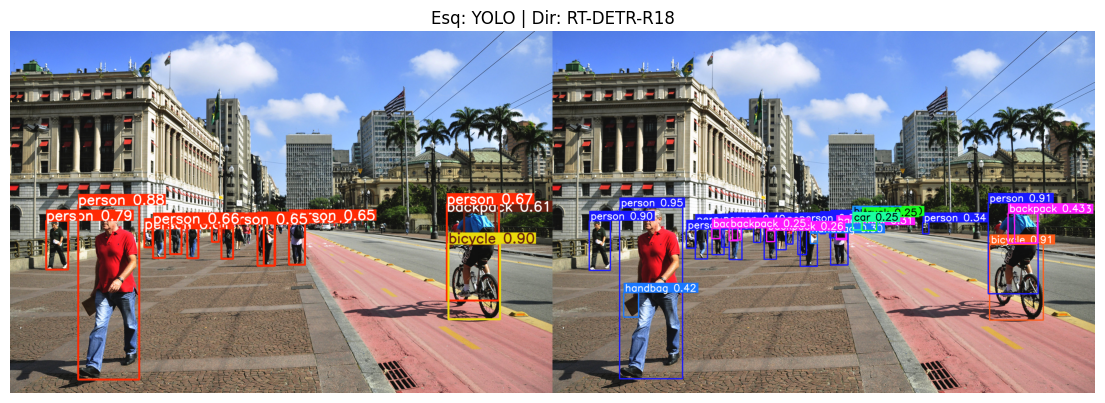

In [13]:
def draw_yolo_rgb(img_rgb, yres):
    out = yres.plot()  # o Ultralytics já desenha
    return out

def draw_rtdetr_rgb(img_rgb, rres):
    return draw_rtdetr(img_rgb, rres)  # função que te mandei

img = get_imgs(path)[0]
yres = infer_yolo(img)
rres = infer_rtdetr(img)

rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
y_anno = draw_yolo_rgb(rgb, yres)
r_anno = draw_rtdetr_rgb(rgb, rres)
side = cv2.cvtColor(cv2.hconcat([cv2.cvtColor(y_anno, cv2.COLOR_RGB2BGR),
                                 cv2.cvtColor(r_anno, cv2.COLOR_RGB2BGR)]),
                    cv2.COLOR_BGR2RGB)

import matplotlib.pyplot as plt
plt.figure(figsize=(14,6))
plt.imshow(side); plt.axis('off')
plt.title("Esq: YOLO | Dir: RT-DETR-R18")
plt.show()

### Comparação com métrica

In [14]:
import time, cv2, torch
from collections import Counter

# --- helpers ---
def iou_xyxy(a, b):
    ax1, ay1, ax2, ay2 = a; bx1, by1, bx2, by2 = b
    ix1, iy1 = max(ax1, bx1), max(ay1, by1)
    ix2, iy2 = min(ax2, bx2), min(ay2, by2)
    iw, ih = max(0, ix2-ix1), max(0, iy2-iy1)
    inter = iw*ih
    if inter <= 0: return 0.0
    area_a = (ax2-ax1)*(ay2-ay1); area_b = (bx2-bx1)*(by2-by1)
    return inter / (area_a + area_b - inter + 1e-9)

def greedy_match(boxesA, labelsA, boxesB, labelsB, iou_thr=0.5):
    usedB, matches = set(), 0
    for i, la in enumerate(labelsA):
        best, best_j = 0.0, -1
        for j, lb in enumerate(labelsB):
            if j in usedB or lb != la: continue
            iou = iou_xyxy(boxesA[i], boxesB[j])
            if iou > best: best, best_j = iou, j
        if best_j >= 0 and best >= iou_thr:
            usedB.add(best_j); matches += 1
    covA = matches / max(1, len(boxesA))
    covB = matches / max(1, len(boxesB))
    return matches, covA, covB

def measure_latency(fn, img, runs=1):
    if torch.cuda.is_available(): torch.cuda.synchronize()
    t0 = time.perf_counter()
    for _ in range(runs): _ = fn(img)
    if torch.cuda.is_available(): torch.cuda.synchronize()
    return (time.perf_counter() - t0) / runs

# --- comparação principal ---
def compare_detectors(path, iou_thr=0.50, yolo_conf=0.50, rtdetr_conf=0.50, roi=None):
    imgs = get_imgs(path)
    if not imgs:
        print("Sem imagens em:", path); return

    lat = {"yolo": [], "rtdetr": []}
    det_counts = {"yolo": [], "rtdetr": []}
    class_counts = {"yolo": Counter(), "rtdetr": Counter()}
    covY, covR = [], []

    # wrappers com conf alinhado
    def run_yolo(img):
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        res = yolo_model.predict(rgb, conf=yolo_conf, verbose=False)[0]
        return res
    def run_rtdetr(img):
        return get_rtdetr_objects(rtdetr_model, rtdetr_processor, img, device, score_threshold=rtdetr_conf)

    for img in imgs:
        # latência
        lat["yolo"].append(measure_latency(run_yolo, img))
        y = run_yolo(img)
        lat["rtdetr"].append(measure_latency(run_rtdetr, img))
        r = run_rtdetr(img)

        # caixas e classes (opcionalmente recorte por ROI)
        def to_xyxy_labels(res):
            boxes = [b.xyxy[0].int().cpu().numpy().tolist() for b in res.boxes]
            labels = [int(b.cls[0]) for b in res.boxes]
            if roi is not None:
                x1r,y1r,x2r,y2r = roi
                keep = []
                for (x1,y1,x2,y2), lab in zip(boxes, labels):
                    cx, cy = (x1+x2)/2, (y1+y2)/2
                    if x1r <= cx <= x2r and y1r <= cy <= y2r:
                        keep.append((x1,y1,x2,y2,lab))
                boxes = [[a,b,c,d] for a,b,c,d,_ in keep]
                labels = [lab for *_, lab in keep]
            return boxes, labels

        yb, yl = to_xyxy_labels(y)
        rb, rl = to_xyxy_labels(r)

        det_counts["yolo"].append(len(yb))
        det_counts["rtdetr"].append(len(rb))
        for lid in yl: class_counts["yolo"][y.names[lid]] += 1
        for lid in rl: class_counts["rtdetr"][r.names[lid]] += 1

        # acordo (IoU por classe)
        _, cY, cR = greedy_match(yb, yl, rb, rl, iou_thr=iou_thr)
        covY.append(cY); covR.append(cR)

    avg = lambda xs: sum(xs)/max(1,len(xs))
    print("=== Velocidade ===")
    print(f"YOLO   : {avg(lat['yolo'])*1000:.1f} ms  | FPS ≈ {1.0/avg(lat['yolo']):.1f}")
    print(f"RT-DETR: {avg(lat['rtdetr'])*1000:.1f} ms  | FPS ≈ {1.0/avg(lat['rtdetr']):.1f}")

    print("\n=== Cobertura (detecções por imagem) ===")
    print(f"YOLO   : {avg(det_counts['yolo']):.2f}")
    print(f"RT-DETR: {avg(det_counts['rtdetr']):.2f}")

    print(f"\n=== Acordo (IoU ≥ {iou_thr:.2f}, mesma classe) ===")
    print(f"Cobertura YOLO→RT : {avg(covY)*100:.1f}%")
    print(f"Cobertura RT→YOLO : {avg(covR)*100:.1f}%")

    print("\n=== Top classes (10) ===")
    print("YOLO   :", class_counts["yolo"].most_common(10))
    print("RT-DETR:", class_counts["rtdetr"].most_common(10))

In [15]:
H, W = get_imgs(path)[0].shape[:2]
roi = (W//6, 0, (W*5)//6, H)  # opcional
compare_detectors(path, iou_thr=0.5, yolo_conf=0.50, rtdetr_conf=0.50, roi=roi)

=== Velocidade ===
YOLO   : 49.9 ms  | FPS ≈ 20.1
RT-DETR: 448.8 ms  | FPS ≈ 2.2

=== Cobertura (detecções por imagem) ===
YOLO   : 7.00
RT-DETR: 10.00

=== Acordo (IoU ≥ 0.50, mesma classe) ===
Cobertura YOLO→RT : 100.0%
Cobertura RT→YOLO : 70.0%

=== Top classes (10) ===
YOLO   : [('person', 7)]
RT-DETR: [('person', 9), ('car', 1)]


O que essas métricas dizem:
- Velocidade: latência média (ms) e FPS.
- Cobertura: quantas caixas por imagem (útil p/ ver se um é mais “falante”).
- Acordo (IoU): porcentagem de caixas de um modelo que têm par no outro (mesma classe, IoU≥τ).
    - YOLO→RT 80% = 80% das caixas do YOLO aparecem no RT-DETR.
    - RT→YOLO 65% = RT-DETR está vendo mais coisas (ou ruído) que YOLO não vê.

Dica: alinhe os thresholds (ex.: yolo_conf=0.50, rtdetr_conf=0.50) para uma comparação justa; teste também IoU 0.6/0.7.

In [16]:
import cv2, os

def extract_frames(video_path, out_dir="tmp_frames", stride=5, max_frames=500):
    os.makedirs(out_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    i = saved = 0
    while cap.isOpened() and saved < max_frames:
        ret, frame = cap.read()
        if not ret: break
        if i % stride == 0:
            cv2.imwrite(os.path.join(out_dir, f"{i:06d}.jpg"), frame)
            saved += 1
        i += 1
    cap.release()
    print(f"Salvos {saved} frames em {out_dir}")

extract_frames("video-t3/video-trabalho3.mp4", stride=50, max_frames=100)
compare_detectors("tmp_frames/", iou_thr=0.5, yolo_conf=0.50, rtdetr_conf=0.50)

Salvos 18 frames em tmp_frames
=== Velocidade ===
YOLO   : 52.5 ms  | FPS ≈ 19.0
RT-DETR: 503.4 ms  | FPS ≈ 2.0

=== Cobertura (detecções por imagem) ===
YOLO   : 0.67
RT-DETR: 4.56

=== Acordo (IoU ≥ 0.50, mesma classe) ===
Cobertura YOLO→RT : 52.8%
Cobertura RT→YOLO : 10.4%

=== Top classes (10) ===
YOLO   : [('cat', 4), ('tv', 3), ('chair', 3), ('laptop', 1), ('person', 1)]
RT-DETR: [('book', 38), ('chair', 12), ('tvmonitor', 10), ('cat', 6), ('mouse', 5), ('cup', 3), ('refrigerator', 2), ('laptop', 2), ('keyboard', 1), ('diningtable', 1)]


In [17]:
path = "imagens-t3/comparison-1/frankfurt"
compare_detectors(path, iou_thr=0.5, yolo_conf=0.50, rtdetr_conf=0.50)

=== Velocidade ===
YOLO   : 55.3 ms  | FPS ≈ 18.1
RT-DETR: 534.7 ms  | FPS ≈ 1.9

=== Cobertura (detecções por imagem) ===
YOLO   : 4.64
RT-DETR: 10.79

=== Acordo (IoU ≥ 0.50, mesma classe) ===
Cobertura YOLO→RT : 89.2%
Cobertura RT→YOLO : 40.1%

=== Top classes (10) ===
YOLO   : [('car', 145), ('person', 135), ('truck', 11), ('bicycle', 5), ('bus', 4), ('traffic light', 3), ('handbag', 1), ('boat', 1), ('suitcase', 1)]
RT-DETR: [('car', 307), ('person', 265), ('traffic light', 47), ('bicycle', 43), ('truck', 18), ('bus', 9), ('handbag', 6), ('motorbike', 6), ('suitcase', 3), ('backpack', 2)]


In [18]:
%pip install pycocotools tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 477.3/477.3 kB 252.1 kB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [21]:
import os, glob, cv2, json, torch
from tqdm import tqdm
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

IM_DIR = "imagens-t3/comparison-2/val2017"
ANN_JSON = "imagens-t3/comparison-2/instances_val2017.json"

def xyxy_to_xywh(b):
    x1,y1,x2,y2 = b
    return [float(x1), float(y1), float(x2-x1), float(y2-y1)]

def run_model_on_coco(images_dir, ann_json, infer_fn):
    """Gera predições no formato COCO para um 'infer_fn' (infer_yolo ou infer_rtdetr)."""
    coco = COCO(ann_json)
    # mapa nome->id a partir do GT (evita confusão de índices)
    cat_name_to_id = {c['name']: c['id'] for c in coco.loadCats(coco.getCatIds())}

    img_paths = sorted(glob.glob(os.path.join(images_dir, "*.jpg")))
    preds = []

    for p in tqdm(img_paths, desc="Inferindo"):
        img = cv2.imread(p)
        res = infer_fn(img)  # deve retornar um objeto com .boxes e .names

        # COCO usa id numérico do nome do arquivo (sem extensão)
        image_id = int(os.path.splitext(os.path.basename(p))[0])

        for b in res.boxes:
            x1, y1, x2, y2 = b.xyxy[0].int().cpu().numpy().tolist()
            cls_id = int(b.cls[0])
            name   = res.names[cls_id]
            # mapeia para id do COCO; se não existir, pula
            if name not in cat_name_to_id:
                continue
            cat_id = cat_name_to_id[name]
            score  = float(getattr(b, "conf", torch.tensor([1.0]))[0])  # YOLO e RT-DETR (adaptador) têm .conf

            preds.append({
                "image_id": image_id,
                "category_id": int(cat_id),
                "bbox": xyxy_to_xywh([x1,y1,x2,y2]),
                "score": score
            })
    return preds

def evaluate_coco(ann_json, preds):
    coco_gt = COCO(ann_json)
    coco_dt = coco_gt.loadRes(preds) if isinstance(preds, list) else coco_gt.loadRes(json.load(open(preds)))
    E = COCOeval(coco_gt, coco_dt, iouType='bbox')
    E.evaluate(); E.accumulate(); E.summarize()  # imprime mAP@[.50:.95], mAP@0.5, AR, etc.

# >>> YOLO
preds_yolo = run_model_on_coco(IM_DIR, ANN_JSON, infer_yolo)
evaluate_coco(ANN_JSON, preds_yolo)

# >>> RT-DETR-R18
preds_rtdetr = run_model_on_coco(IM_DIR, ANN_JSON, infer_rtdetr)
evaluate_coco(ANN_JSON, preds_rtdetr)


loading annotations into memory...
Done (t=0.54s)
creating index...
index created!


Inferindo: 100%|██████████| 5000/5000 [04:21<00:00, 19.11it/s]


loading annotations into memory...
Done (t=0.50s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.24s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=7.48s).
Accumulating evaluation results...
DONE (t=1.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.262
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.357
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.288
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.080
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.285
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.407
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.227
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.305
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Inferindo: 100%|██████████| 5000/5000 [36:11<00:00,  2.30it/s]


loading annotations into memory...
Done (t=0.55s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.34s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=11.47s).
Accumulating evaluation results...
DONE (t=1.52s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.400
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.557
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.429
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.228
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.438
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.566
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.306
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.479
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet